In [1]:
from datetime import datetime
current_datetime = datetime.today().strftime("%Y-%m-%d %H:%M:%S")
print(current_datetime)

2020-11-25 15:19:01


# Pull, Visualize and Play the data from Archiver Appliance

This notebook shows how to use **pyarchappl** Python package to work with Archiver Appliance web service, along with a practical use case, which shows how to extract the machine settings from the recorded data, based on the machine performance trends with timestamps, which could also be visualized with the data.
    
Furthermore, it also shows how to interface the high-level application so-called **Settings Manager**, by exporting the extracted settings data into a data file and loading into, as such, other operations could be well performed in the context of Settings Manager.

<hr>

Tong Zhang <zhangt@frib.msu.edu>

Last updated: 2020-11-25

## Introduction of **pyarchappl**
* Python package for communicating with Archiver Appliance web application
* Develop with Python 3.x
* Integration with _PHANTASY_ framework, if **phantasy** is installed
* Work data with **pandas**
* Hosted on GitHub

In [2]:
import archappl
print(archappl.__doc__)
print("Version: ", archappl.__version__)
print("Author : ", archappl.__author__)

archappl: Python interface of Archiver Appliance.
Version:  0.9.0
Author :  Tong Zhang <zhangt@frib.msu.edu>


In [3]:
from archappl.contrib import get_dataset
get_dataset?

```
Signature: get_dataset(element_list, field_list, from_time, to_time, **kws)
Docstring:
Pull data from Archiver Appliance, with a given list of devices and dynamic fields,
within defined time slot.

Parameters
----------
element_list : list
    A list of high-level device element objects.
field_list : list
    A list of field names should applied to all elements, otherwise skip invalid field which
    does not belong to some element.
from_time : str
    A string of start time of the data in ISO8601 format.
to_time : str
    A string of end time of the data in ISO8601 format.

Keyword Arguments
-----------------
client : ArchiverDataClient
    ArchiverDataClient instance, default is FRIBArchiverDataClient.
resample : str
    The offset string or object representing target conversion, e.g. resample with 1 second
    offset could be defined as '1S'.
verbose : int
    Verbosity level of the log output, default is 0, no output, 1, output progress, 2 output
    progress with description.
handle : str
    PV handle for field list, by default is 'readback', other options: 'setpoint'.

Returns
-------
r : dataframe
    Pandas dataframe with datetime as the index, and device PV names as columns

See Also
--------
get_dataset
phantasy.CaElement, phantasy.CaField
archappl.dformat

Examples
--------
>>> from archappl.client import ArchiverDataClient
>>> data_client = ArchiverDataClient()
>>> data_client.url = "http://127.0.0.1:17665"
>>>
>>> from phantasy import MachinePortal
>>> mp = MachinePortal("FRIB_VA", "LS1FS1")
>>> bpms = mp.get_elements(type="BPM")

>>> from archappl import dformat
>>> t0 = dformat(2020, 11, 16, 15, 10)
>>> t1 = dformat(2020, 11, 16, 16, 17)
>>> field_list = ['X', 'Y']
>>> data_set = get_dataset_with_devices(bpms, field_list, t0, t1,
                                        resample="1S", verbose=2,
                                        client=data_client)
```

In [4]:
from archappl.contrib import get_dataset_at_time
get_dataset_at_time?

```
Signature: get_dataset_at_time(element_list, field_list, at_time, **kws)
Docstring:
Pull data from Archiver Appliance, with a given list of devices and dynamic fields at a
specified time.

Parameters
----------
element_list : list
    A list of high-level device element objects.
field_list : list
    A list of field names should applied to all elements, otherwise skip invalid field which
    does not belong to some element.
at_time : str
    A string of time of the data in ISO8601 format.

Keyword Arguments
-----------------
client : ArchiverDataClient
    ArchiverDataClient instance, default is FRIBArchiverDataClient.
handle : str
    PV handle for field list, by default is 'readback', other options: 'setpoint'.
tz : str
    Name of timezone for the returned index, default is local zone.

Returns
-------
r : dataframe
    Pandas dataframe.
```

In [5]:
from archappl import dformat
dformat?

_dformat_ is convenient function provided by **pyarchappl**, which can correctly handle the datetime, by default the time is localized at time zone of 'America/New_York'.

```
Signature: dformat(*args, **kws)
Docstring:
Return ISO8601 format of date time.

Input up to 7 arguments as year, month, day, hour, minute, second,
millisecond, it is recommended always input year, month, day, hour,
minute, second and millisecond as 0 if not input.
```

## Set up data client

The data client is the client that send request to and receive response from Archiver Appliance.  

In this notebook, all the data are retrieved from a local hosted Archiver Appliance, for FRIB FTC, just use _FRIBArchiverDataClient_.

In [6]:
from archappl.client import ArchiverDataClient

data_client = ArchiverDataClient()
data_client.url = "http://127.0.0.1:17665"  # local hosted Archiver Appliance

In [7]:
# For FRIB FTC working environment, use FRIBArchiverDataClient
from archappl.client import FRIBArchiverDataClient

## Set up devices, work with high-level devices

In this notebook, archived data are from virtual accelerator, trajectory correction with ORM app is used to change the machine status, changes are recorded by Archiver Appliance.

For FRIB FTC, set _machine_ and _segment_ with 'FRIB' and 'LINAC'.

The data integration with FRIB high-level physics controls is achieved via **phantasy**, for those **phantasy** is not available, other generic data structure is returned.

In [8]:
from phantasy import MachinePortal

mp = MachinePortal(machine="FRIB_VA", segment="LS1FS1")

# get all the BPMs and Correctors
bpms = mp.get_elements(type="BPM")
hcors = mp.get_elements(type='HCOR')
vcors = mp.get_elements(type='VCOR')

[15:19:02.536] INFO: phantasy.library.operation.core: Load new machine: 'FRIB_VA', segment: 'LS1FS1'
[15:19:02.536] INFO: phantasy.library.parser.config: Importing FRIB_VA from /home/tong/Dropbox/phantasy-project/phantasy-machines/FRIB_VA
[15:19:02.538] INFO: phantasy.library.parser.config: Loading machine configuration from /home/tong/Dropbox/phantasy-project/phantasy-machines/FRIB_VA/phantasy.ini
[15:19:02.538] INFO: phantasy.library.operation.lattice: Loading segment: 'LS1FS1'
[15:19:02.540] WARNING: phantasy.library.operation.lattice: Default UNICORN policy will be applied.
[15:19:02.541] WARNING: phantasy.library.operation.lattice: Default device polarity will be applied.
[15:19:02.542] INFO: phantasy.library.operation.lattice: Loading PV data from CSV/SQLite: /home/tong/Dropbox/phantasy-project/phantasy-machines/FRIB_VA/ls1fs1/channels.csv
[15:19:02.543] INFO: phantasy.library.pv.datasource: Set source to be CSV table: channels.csv.
[15:19:02.625] INFO: phantasy.library.operation

In [9]:
# Only choose the devices that are controllable

lat = mp.work_lattice_conf
non_diag_devices = [i for i in lat if not i.is_diag()]
non_diag_devices

[LS1_CA01:CAV1_D1127 [CAV] @ sb=0.218087,
 LS1_CA01:SOL1_D1132 [SOL] @ sb=0.685364,
 LS1_CA01:DCV_D1132 [VCOR] @ sb=0.785365,
 LS1_CA01:DCH_D1132 [HCOR] @ sb=0.785365,
 LS1_CA01:CAV2_D1136 [CAV] @ sb=1.059770,
 LS1_CA01:CAV3_D1142 [CAV] @ sb=1.693326,
 LS1_CA01:SOL2_D1146 [SOL] @ sb=2.160603,
 LS1_CA01:DCV_D1146 [VCOR] @ sb=2.260604,
 LS1_CA01:DCH_D1146 [HCOR] @ sb=2.260604,
 LS1_CA01:CAV4_D1150 [CAV] @ sb=2.535008,
 LS1_CA02:CAV1_D1161 [CAV] @ sb=3.591182,
 LS1_CA02:SOL1_D1165 [SOL] @ sb=4.058459,
 LS1_CA02:DCV_D1165 [VCOR] @ sb=4.158460,
 LS1_CA02:DCH_D1165 [HCOR] @ sb=4.158460,
 LS1_CA02:CAV2_D1169 [CAV] @ sb=4.432864,
 LS1_CA02:CAV3_D1176 [CAV] @ sb=5.066420,
 LS1_CA02:SOL2_D1180 [SOL] @ sb=5.533698,
 LS1_CA02:DCV_D1180 [VCOR] @ sb=5.633699,
 LS1_CA02:DCH_D1180 [HCOR] @ sb=5.633699,
 LS1_CA02:CAV4_D1184 [CAV] @ sb=5.908104,
 LS1_CA03:CAV1_D1195 [CAV] @ sb=6.964276,
 LS1_CA03:SOL1_D1199 [SOL] @ sb=7.431554,
 LS1_CA03:DCV_D1199 [VCOR] @ sb=7.531555,
 LS1_CA03:DCH_D1199 [HCOR] @ sb=7.

## Define the time range for data retrieval

Retrieve data in a time range defined by _from_ one time _to_ another time, the time should be formated as ISO-8601 format, **pyarchappl** correctly handles the daylight saving time zone, e.g. in America/New_York zone.

By default, the input tuple of time to function _dformat_ is localized at America/New_York.

In [10]:
# Define the time range from 2020-11-16, 15:10 to 2020-11-16, 16:17, EST

t0 = dformat(2020, 11, 16, 15, 10) 
t1 = dformat(2020, 11, 16, 16, 17)

# The output t0 and t1 is converted to UTC time zone, which is 5 hours ahead of EST now.
print(t0)
print(t1)

2020-11-16T20:10:00.000Z
2020-11-16T21:17:00.000Z


## Retrieve all the BPM X Y readings in defined time range

Additionally, do:
1. Align the timestamps
2. Resample the data rate at 1 second
3. Show the retrieving progress

Which could be achieved by setting the parameters of function _get_dataset()_.

In [11]:
data_set = get_dataset(bpms, ['X', 'Y'], t0, t1,
                       resample="1S", verbose=1, client=data_client)

# set verbose > 0 will display a progress bar for the retrieval, in this case, totally made 150 requests. 


[2020-11-25T15:19:07.948035] Fetched all, time cost: 4.8 seconds.


## Show the retrieved data set

In [12]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4020 entries, 2020-11-16 15:10:00-05:00 to 2020-11-16 16:16:59-05:00
Freq: S
Columns: 150 entries, VA:LS1_CA01:BPM_D1129:X_RD to VA:FS1_BMS:BPM_D2702:Y_RD
dtypes: float64(150)
memory usage: 4.6 MB


In [13]:
data_set.describe()

,VA:LS1_CA01:BPM_D1129:X_RD,VA:LS1_CA01:BPM_D1129:Y_RD,VA:LS1_CA01:BPM_D1144:X_RD,VA:LS1_CA01:BPM_D1144:Y_RD,VA:LS1_WA01:BPM_D1155:X_RD,VA:LS1_WA01:BPM_D1155:Y_RD,VA:LS1_CA02:BPM_D1163:X_RD,VA:LS1_CA02:BPM_D1163:Y_RD,VA:LS1_CA02:BPM_D1177:X_RD,VA:LS1_CA02:BPM_D1177:Y_RD,...,VA:FS1_BMS:BPM_D2587:X_RD,VA:FS1_BMS:BPM_D2587:Y_RD,VA:FS1_BMS:BPM_D2600:X_RD,VA:FS1_BMS:BPM_D2600:Y_RD,VA:FS1_BMS:BPM_D2665:X_RD,VA:FS1_BMS:BPM_D2665:Y_RD,VA:FS1_BMS:BPM_D2690:X_RD,VA:FS1_BMS:BPM_D2690:Y_RD,VA:FS1_BMS:BPM_D2702:X_RD,VA:FS1_BMS:BPM_D2702:Y_RD
count,4.020000e+03,4.020000e+03,4.020000e+03,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,...,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000
mean,5.318739e-06,-7.408959e-06,-1.179285e-04,-0.000336,-0.000958,-0.000963,-0.001801,-0.002056,0.000712,0.000353,...,-0.000329,-0.008596,-0.004140,-0.005371,-0.005903,-0.002286,0.000666,0.000194,0.002451,0.002098
std,2.496021e-09,1.772378e-07,4.913073e-07,0.000001,0.001051,0.001018,0.002396,0.002345,0.000726,0.000698,...,0.001118,0.007362,0.005924,0.004485,0.006434,0.000838,0.001859,0.000911,0.003520,0.001108
min,5.314098e-06,-7.742169e-06,-1.190655e-04,-0.000340,-0.002377,-0.002340,-0.005043,-0.005230,0.000008,-0.000221,...,-0.014774,-0.020388,-0.034180,-0.012603,-0.015101,-0.005383,-0.001147,-0.001378,-0.000427,-0.000011
25%,5.316601e-06,-7.560853e-06,-1.183103e-04,-0.000337,-0.002369,-0.002329,-0.005016,-0.005201,0.000203,-0.000215,...,-0.001634,-0.017976,-0.011855,-0.011067,-0.014445,-0.002700,-0.000863,-0.000598,-0.000246,0.001670
50%,5.318709e-06,-7.408243e-06,-1.179311e-04,-0.000336,-0.000170,-0.000230,-0.000006,-0.000367,0.000206,-0.000106,...,0.000332,-0.003966,0.000205,-0.002593,-0.001339,-0.002630,-0.000490,-0.000308,-0.000133,0.001716
75%,5.320892e-06,-7.257442e-06,-1.175302e-04,-0.000335,-0.000168,-0.000228,-0.000001,-0.000363,0.001661,0.001283,...,0.000596,-0.003794,0.000389,-0.002487,-0.001272,-0.002299,0.002913,0.001306,0.007041,0.003281
max,5.323512e-06,-7.084694e-06,-1.167591e-04,-0.000333,-0.000087,-0.000059,0.000065,0.000028,0.001790,0.001299,...,0.000806,0.000108,0.000703,0.000063,0.000039,0.000017,0.020418,0.001960,0.019851,0.004013


In [14]:
data_set.head(2)

,VA:LS1_CA01:BPM_D1129:X_RD,VA:LS1_CA01:BPM_D1129:Y_RD,VA:LS1_CA01:BPM_D1144:X_RD,VA:LS1_CA01:BPM_D1144:Y_RD,VA:LS1_WA01:BPM_D1155:X_RD,VA:LS1_WA01:BPM_D1155:Y_RD,VA:LS1_CA02:BPM_D1163:X_RD,VA:LS1_CA02:BPM_D1163:Y_RD,VA:LS1_CA02:BPM_D1177:X_RD,VA:LS1_CA02:BPM_D1177:Y_RD,...,VA:FS1_BMS:BPM_D2587:X_RD,VA:FS1_BMS:BPM_D2587:Y_RD,VA:FS1_BMS:BPM_D2600:X_RD,VA:FS1_BMS:BPM_D2600:Y_RD,VA:FS1_BMS:BPM_D2665:X_RD,VA:FS1_BMS:BPM_D2665:Y_RD,VA:FS1_BMS:BPM_D2690:X_RD,VA:FS1_BMS:BPM_D2690:Y_RD,VA:FS1_BMS:BPM_D2702:X_RD,VA:FS1_BMS:BPM_D2702:Y_RD
time,,,,,,,,,,,,,,,,,,,,,
2020-11-16 15:10:00-05:00,0.000005,-0.000008,-0.000118,-0.000336,-0.000087,-0.000095,-2.884984e-07,-0.000364,0.0002,-0.000218,...,0.000679,-0.003908,0.000518,-0.002564,-0.001352,-0.002718,-0.000976,-0.000615,-0.000319,0.001734
2020-11-16 15:10:01-05:00,0.000005,-0.000008,-0.000118,-0.000336,-0.000087,-0.000095,-2.884984e-07,-0.000364,0.0002,-0.000218,...,0.000679,-0.003908,0.000518,-0.002564,-0.001352,-0.002718,-0.000976,-0.000615,-0.000319,0.001734


In [15]:
data_set.tail(2)

,VA:LS1_CA01:BPM_D1129:X_RD,VA:LS1_CA01:BPM_D1129:Y_RD,VA:LS1_CA01:BPM_D1144:X_RD,VA:LS1_CA01:BPM_D1144:Y_RD,VA:LS1_WA01:BPM_D1155:X_RD,VA:LS1_WA01:BPM_D1155:Y_RD,VA:LS1_CA02:BPM_D1163:X_RD,VA:LS1_CA02:BPM_D1163:Y_RD,VA:LS1_CA02:BPM_D1177:X_RD,VA:LS1_CA02:BPM_D1177:Y_RD,...,VA:FS1_BMS:BPM_D2587:X_RD,VA:FS1_BMS:BPM_D2587:Y_RD,VA:FS1_BMS:BPM_D2600:X_RD,VA:FS1_BMS:BPM_D2600:Y_RD,VA:FS1_BMS:BPM_D2665:X_RD,VA:FS1_BMS:BPM_D2665:Y_RD,VA:FS1_BMS:BPM_D2690:X_RD,VA:FS1_BMS:BPM_D2690:Y_RD,VA:FS1_BMS:BPM_D2702:X_RD,VA:FS1_BMS:BPM_D2702:Y_RD
time,,,,,,,,,,,,,,,,,,,,,
2020-11-16 16:16:58-05:00,0.000005,-0.000007,-0.000118,-0.000337,-0.000143,-0.000062,0.000056,0.000021,0.000013,-0.000005,...,0.000008,0.000068,0.000012,0.000041,-8.031803e-08,-0.000006,-0.00002,-0.000011,0.000006,-0.000005
2020-11-16 16:16:59-05:00,0.000005,-0.000007,-0.000118,-0.000337,-0.000143,-0.000062,0.000056,0.000021,0.000013,-0.000005,...,0.000008,0.000068,0.000012,0.000041,-8.031803e-08,-0.000006,-0.00002,-0.000011,0.000006,-0.000005


## Plot the trajectory distribution along time range

### Extract X and Y trajectory readings

In [16]:
data_set_x = data_set.iloc[:, 0::2]
data_set_y = data_set.iloc[:, 1::2]

In [17]:
data_set_x.head(2)

,VA:LS1_CA01:BPM_D1129:X_RD,VA:LS1_CA01:BPM_D1144:X_RD,VA:LS1_WA01:BPM_D1155:X_RD,VA:LS1_CA02:BPM_D1163:X_RD,VA:LS1_CA02:BPM_D1177:X_RD,VA:LS1_WA02:BPM_D1188:X_RD,VA:LS1_CA03:BPM_D1196:X_RD,VA:LS1_CA03:BPM_D1211:X_RD,VA:LS1_WA03:BPM_D1222:X_RD,VA:LS1_CB01:BPM_D1231:X_RD,...,VA:FS1_CSS:BPM_D2383:X_RD,VA:FS1_BBS:BPM_D2421:X_RD,VA:FS1_BBS:BPM_D2466:X_RD,VA:FS1_BMS:BPM_D2502:X_RD,VA:FS1_BMS:BPM_D2537:X_RD,VA:FS1_BMS:BPM_D2587:X_RD,VA:FS1_BMS:BPM_D2600:X_RD,VA:FS1_BMS:BPM_D2665:X_RD,VA:FS1_BMS:BPM_D2690:X_RD,VA:FS1_BMS:BPM_D2702:X_RD
time,,,,,,,,,,,,,,,,,,,,,
2020-11-16 15:10:00-05:00,0.000005,-0.000118,-0.000087,-2.884984e-07,0.0002,0.000083,0.000225,-0.00003,0.000003,-0.000097,...,-0.001219,-0.002086,-0.004205,0.00147,0.001525,0.000679,0.000518,-0.001352,-0.000976,-0.000319
2020-11-16 15:10:01-05:00,0.000005,-0.000118,-0.000087,-2.884984e-07,0.0002,0.000083,0.000225,-0.00003,0.000003,-0.000097,...,-0.001219,-0.002086,-0.004205,0.00147,0.001525,0.000679,0.000518,-0.001352,-0.000976,-0.000319


### Show data as images

In [18]:
from seaborn import heatmap
import matplotlib.pyplot as plt
%matplotlib inline

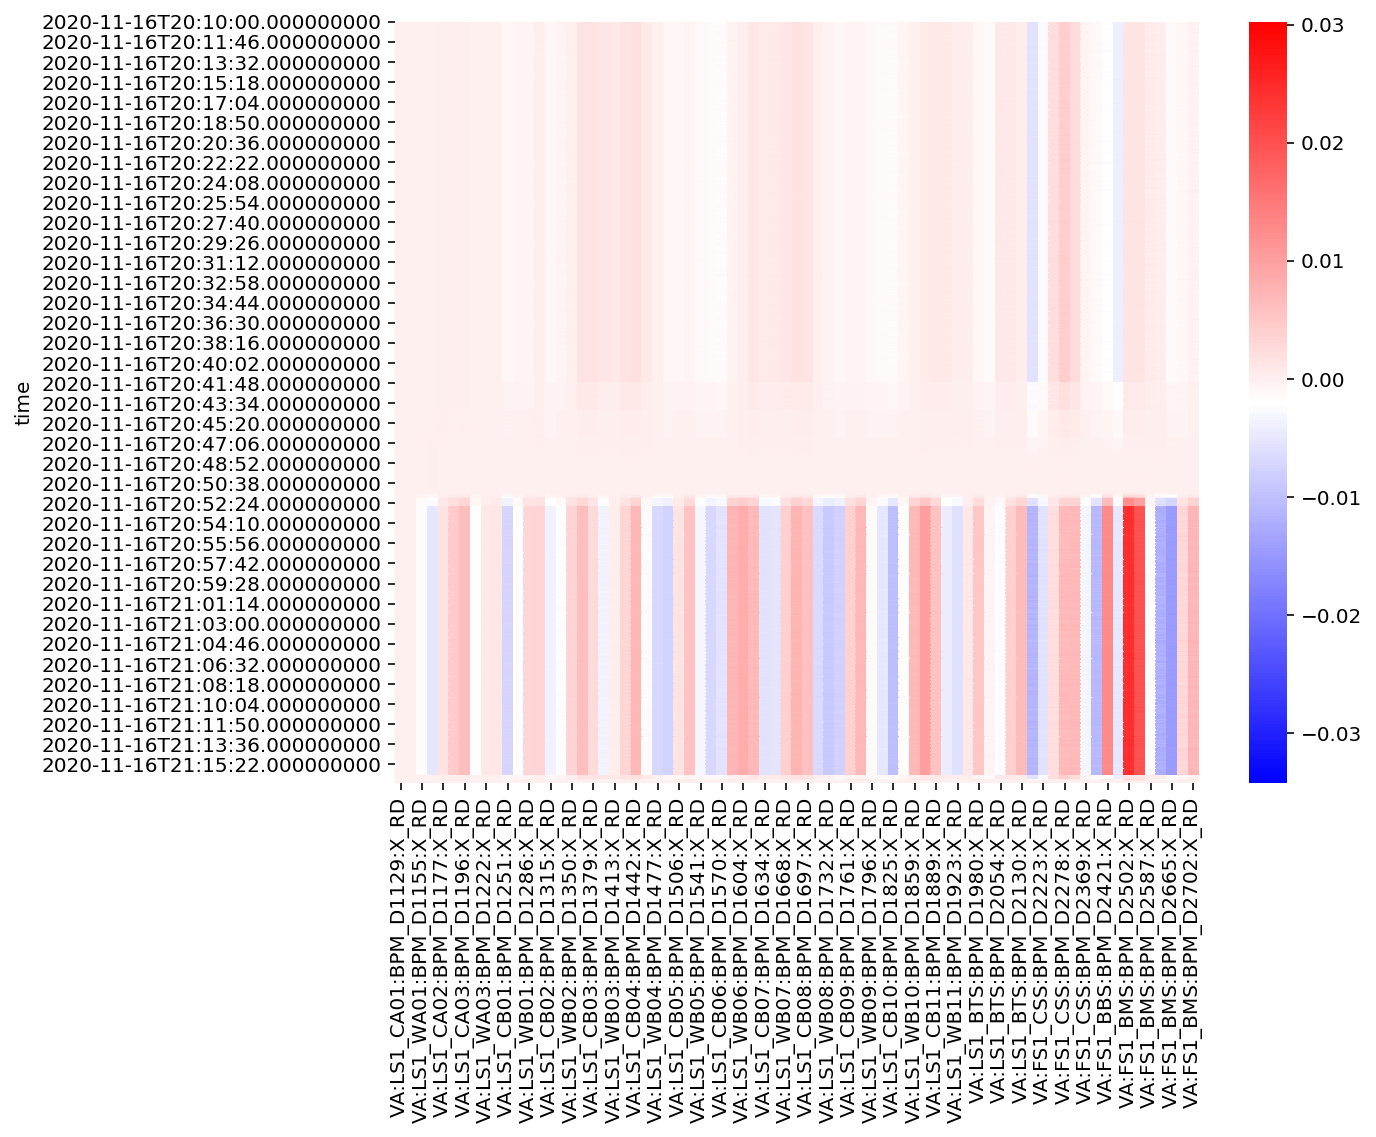

In [19]:
plt.figure(figsize=(9, 7))
heatmap(data_set_x, cmap='bwr')

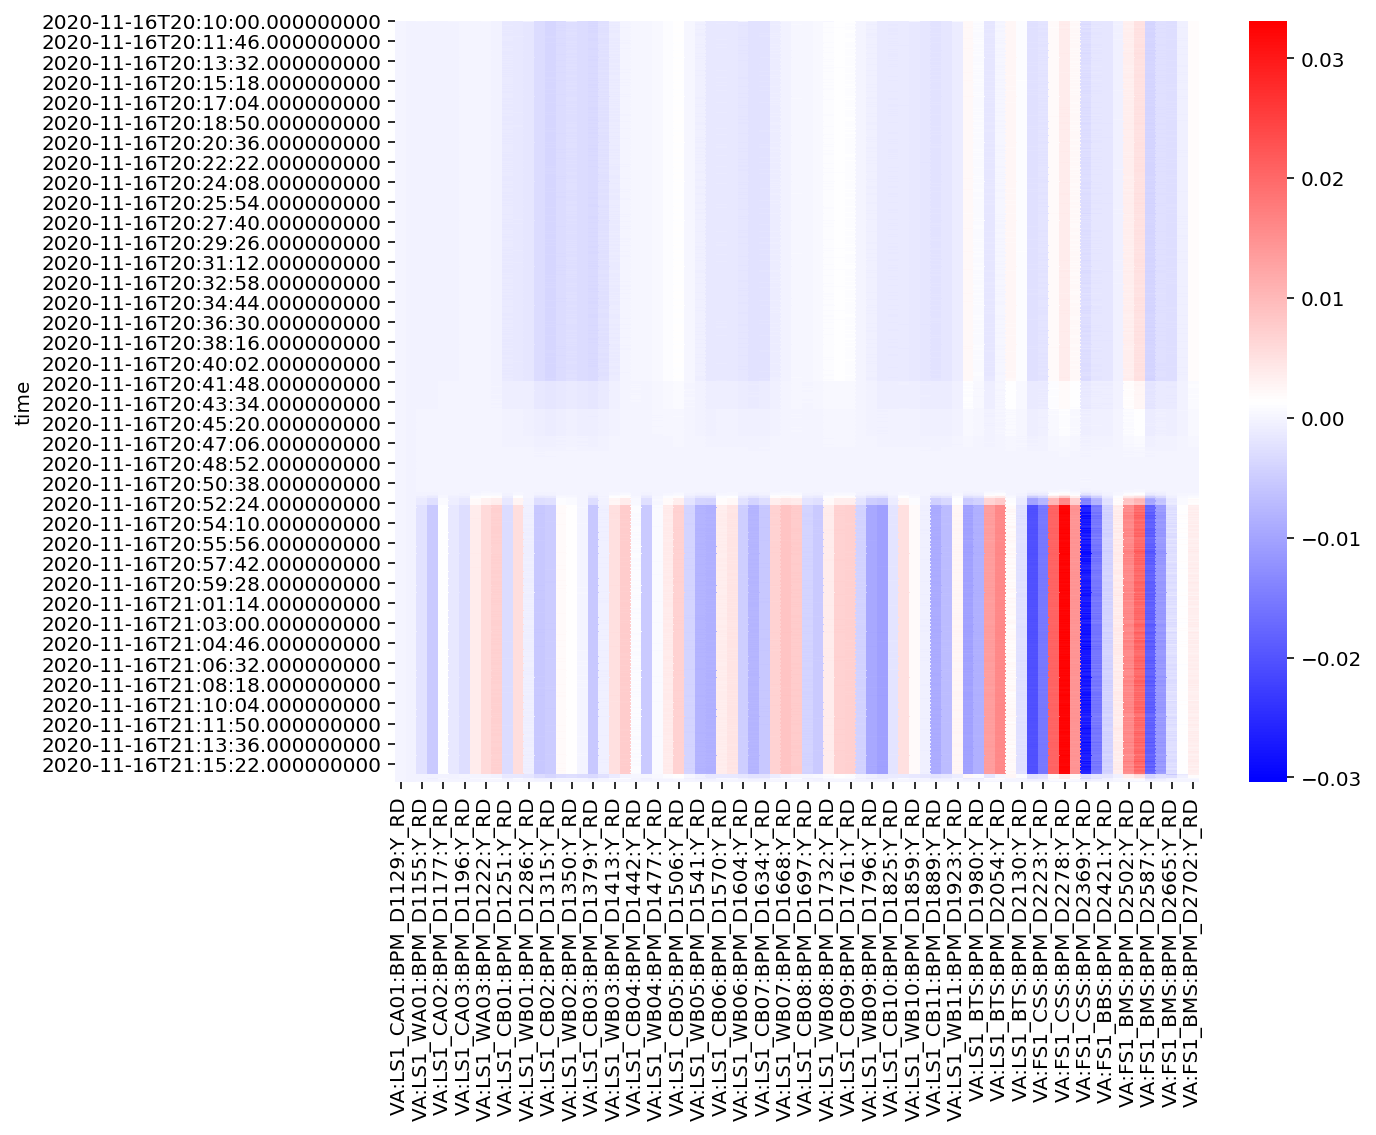

In [20]:
plt.figure(figsize=(9, 7))
heatmap(data_set_y, cmap='bwr')

## Question: What were the machine settings when the trajectory reached minimum?

(When the trajectory correction was performed)

### Show trajectory standard deviation trend

In [21]:
stdx_series = data_set_x.std(axis=1) * 1e3  # m --> mm
stdy_series = data_set_y.std(axis=1) * 1e3  # m --> mm

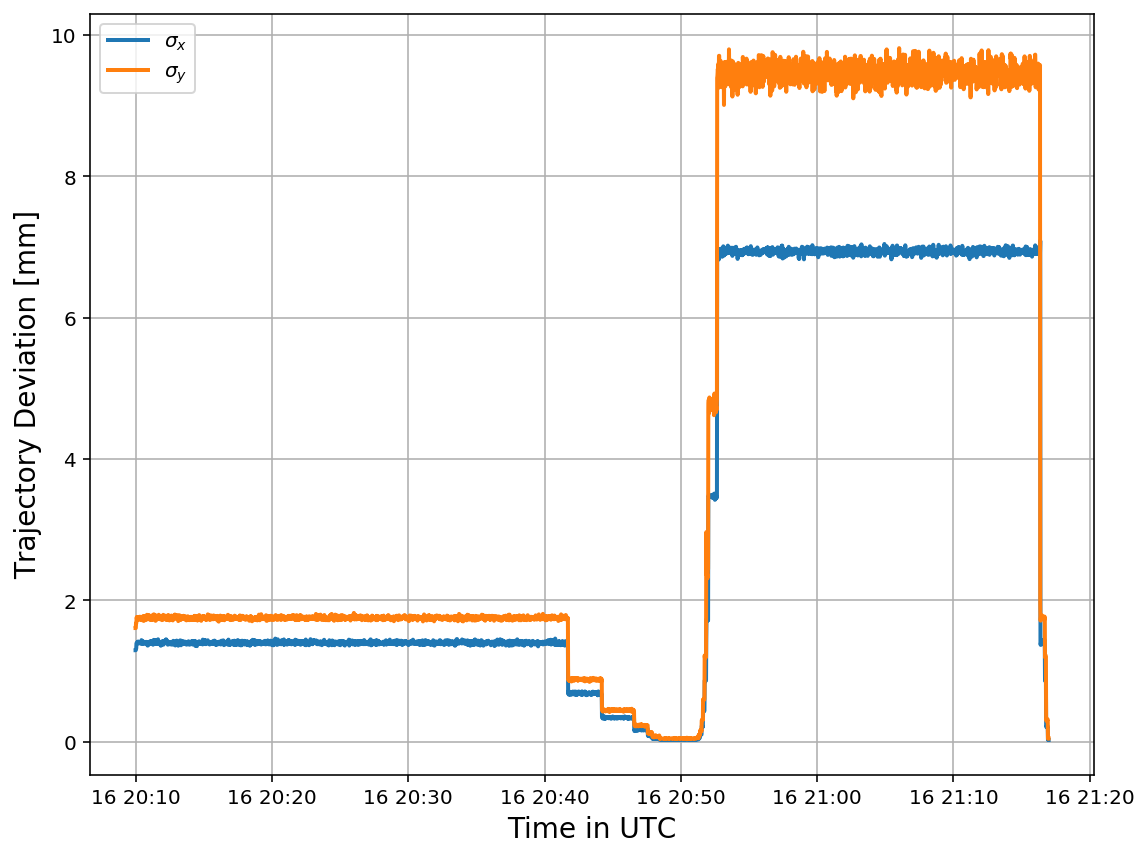

In [22]:
plt.figure(figsize=(9, 7))
plt.plot(stdx_series, label='$\sigma_x$', lw=2)
plt.plot(stdy_series, label='$\sigma_y$', lw=2)
plt.xlabel('Time in UTC', fontsize=14)
plt.ylabel('Trajectory Deviation [mm]', fontsize=14)
plt.grid()
plt.legend()

### Find the timestamp at which both  $\sigma_x$ and $\sigma_y$ reaches minimum

In [23]:
t_min_x = stdx_series.idxmin()
t_min_y = stdy_series.idxmin()
x_min = stdx_series.min()
y_min = stdy_series.min()

print(f"Sigma x reaches min at: {t_min_x}, of value: {x_min:.3f} [mm]")
print(f"Sigma y reaches min at: {t_min_y}, of value: {y_min:.3f} [mm]")

Sigma x reaches min at: 2020-11-16 15:49:06-05:00, of value: 0.024 [mm]
Sigma y reaches min at: 2020-11-16 15:49:13-05:00, of value: 0.043 [mm]


## Retrieve the machine settings at a specific time

```
Signature: get_dataset_at_time(element_list, field_list, at_time, **kws)
Docstring:
Pull data from Archiver Appliance, with a given list of devices and dynamic fields at a
specified time.

Parameters
----------
element_list : list
    A list of high-level device element objects.
field_list : list
    A list of field names should applied to all elements, otherwise skip invalid field which
    does not belong to some element.
at_time : str
    A string of time of the data in ISO8601 format.

Keyword Arguments
-----------------
client : ArchiverDataClient
    ArchiverDataClient instance, default is FRIBArchiverDataClient.
handle : str
    PV handle for field list, by default is 'readback', other options: 'setpoint'.
tz : str
    Name of timezone for the returned index, default is local zone.

Returns
-------
r : dataframe
    Pandas dataframe.
```

In [24]:
# 2020-11-16 15:49:13-05:00
t = dformat(2020, 11, 16, 15, 49, 13) 
df = get_dataset_at_time(non_diag_devices, ['I', 'AMP', 'PHA'], 
                         t, handle='setpoint',
                         client=data_client,
                         tz='America/New_York')

In [25]:
df

,Name,Field,Type,Pos,Setpoint,time
0,LS1_CA01:DCV_D1132,I,VCOR,0.785365,1.455600e-04,2020-11-16 14:20:57.045000-05:00
1,LS1_CA01:DCH_D1132,I,HCOR,0.785365,2.150000e-06,2020-11-16 14:20:56.940000-05:00
2,LS1_CA01:DCV_D1146,I,VCOR,2.260604,1.834400e-04,2020-11-16 15:48:49.753000-05:00
3,LS1_CA01:DCH_D1146,I,HCOR,2.260604,-3.482000e-05,2020-11-16 15:48:49.750000-05:00
4,LS1_CA02:DCV_D1165,I,VCOR,4.158460,1.690400e-04,2020-11-16 15:48:49.764000-05:00
...,...,...,...,...,...,...
113,FS1_BMS:DCH_D2584,I,HCOR,146.052835,-1.300000e-07,2020-11-16 15:48:50.019000-05:00
114,FS1_BMS:DCV_D2640,I,VCOR,151.672285,7.689300e-04,2020-11-16 15:48:50.026000-05:00
115,FS1_BMS:DCH_D2640,I,HCOR,151.672285,2.198000e-05,2020-11-16 15:48:50.025000-05:00
116,FS1_BMS:DCV_D2662,I,VCOR,153.794690,-4.819400e-04,2020-11-16 15:48:50.031000-05:00


## Export settings as a CSV file to work with Settings Manager

1. The user controls where to export the data file
2. The data file can be drag and drop into Settings Manager to work with
3. The data file also can be put into the common data directory where all other settings files are managed 

In [26]:
from archappl.contrib.data import export_as_settings_manager_datafile

```
Signature: export_as_settings_manager_datafile(df, filepath, **kws)
Docstring:
Export dataframe as the datafile for Settings Manager.

Parameters
----------
df : dataframe
    Data of device settings.
filepath : str
    Full path of exported data file.

Keyword Arguments
-----------------
note : str
    Note string.
tags : str
    Tags string.
machine : str
    Name of machine, default is 'FRIB'.
segment : str
    Name of segment, default is 'LINAC'.
```

In [27]:
export_as_settings_manager_datafile(df, f'settings_at_{t}.csv', note='Settings pulled from archiver',
                                    machine='FRIB_VA', segment='LS1FS1')

In [28]:
!cat settings_at_2020-11-16T20\:49\:13.000Z.csv

# timestamp: 1605559639.725576
# datetime: 2020-11-16T15:47:19.725575936-05:00
# note: Settings pulled from archiver
# filepath: settings_at_2020-11-16T20:49:13.000Z.csv
# user: tong
# ion_name: 
# ion_number: 
# ion_mass: 
# ion_charge: 
# machine: FRIB_VA
# segment: LS1FS1
# tags: 
# app: Settings Manager
# version: 5.0
Name,Field,Type,Pos,Setpoint,Readback,Last Setpoint,Tolerance,Writable
LS1_CA01:DCV_D1132,I,VCOR,0.7853645,0.00014556,nan,nan,0.1,True
LS1_CA01:DCH_D1132,I,HCOR,0.7853645,2.15e-06,nan,nan,0.1,True
LS1_CA01:DCV_D1146,I,VCOR,2.2606035,0.00018344,nan,nan,0.1,True
LS1_CA01:DCH_D1146,I,HCOR,2.2606035,-3.482e-05,nan,nan,0.1,True
LS1_CA02:DCV_D1165,I,VCOR,4.1584595,0.00016904,nan,nan,0.1,True
LS1_CA02:DCH_D1165,I,HCOR,4.1584595,-0.00012577,nan,nan,0.1,True
LS1_CA02:DCV_D1180,I,VCOR,5.6336985,0.00014821,nan,nan,0.1,True
LS1_CA02:DCH_D1180,I,HCOR,5.6336985,5.185e-05,nan,nan,0.1,True
LS1_CA03:DCV_D1199,I,VCOR,7.5315545,0.00013771,nan,nan,0.1,True
LS1_CA03:DCH_D1199,I,HCOR,7.531

#### Drag and drop the settings file into Settings Manager:

![loaded_into_settings_manager](Settings_Manager_20201125144515.png)

#### After apply all the device settings, the trajectory shows as before (solid line) and after (w/ marker) changing:

![tv_data_show](Trajectory_Viewer_20201125144603.png)